In [1]:
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

In [2]:
  data = load_boston() 
  X = data.data 
  y = data.target

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing 

In [5]:
X.shape,y.shape  

((506, 13), (506,))

In [6]:
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size = 0.3,random_state =420) 

### 建立一个模型 Xgboost

In [7]:
reg = XGBR(n_estimators  = 100).fit(Xtrain,Ytrain) 
reg.score(Xtest,Ytest) 

0.9050988968414799

In [8]:
MSE(Ytest,reg.predict(Xtest)) 

8.830916343629323

In [10]:
reg.feature_importances_  

array([0.01902167, 0.0042109 , 0.01478316, 0.00553537, 0.02222196,
       0.37914088, 0.01679686, 0.0469872 , 0.04073574, 0.05491759,
       0.06684221, 0.00869464, 0.3201119 ], dtype=float32)

### 交叉验证，与线性回归&随机森林回归进行对比 

In [12]:
# xgboost
reg = XGBR(n_estimators = 100) 
-1* CVS(reg,X,y,cv = 5,scoring = 'neg_mean_squared_error').mean()

19.464340339572285

In [14]:
# random forest 
rfr = RFR(n_estimators = 100) 
-1 * CVS(rfr,X,y,cv = 5,scoring = 'neg_mean_squared_error').mean() 

21.523378496641413

In [16]:
# linear regression 
lr = LinearR() 
-1 * CVS(lr,Xtrain,Ytrain,cv = 5, scoring = 'neg_mean_squared_error').mean() 

25.349507493648424

In [17]:
#开启参数slient：在数据巨大，预料到算法运行会非常缓慢的时候可以使用这个参数来监控模型的训练进度
reg = XGBR(n_estimators=10,silent=False) 
-1* CVS(reg,X,y,cv=5,scoring = 'neg_mean_squared_error').mean()

[15:40:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:40:33] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

21.972280404682667

In [23]:
def plot_learning_curve(estimator,title,X,y,
                        ax = None, 
                        ylim = None, 
                        cv = None, 
                        n_jobs = None): 
            from sklearn.model_selection import learning_curve 
            import matplotlib.pyplot as plt 
            import numpy as np 

            train_sizes, train_scores,test_scores = learning_curve(estimator, X,y,shuffle = True, cv = cv,n_jobs = n_jobs) 

            if ax ==None: 
                ax = plt.gca()  
            else: 
                ax = plt.figure() 
            ax.set_title(title) 
            if ylim is not None: 
                ax.set_ylim(*ylim) 
            ax.set_xlabel('Trainging examples') 
            ax.set_ylabel('score') 
            ax.plot(train_sizes,np.mean(train_scores,axis  =1),'o-',color = 'r',label = 'Training score') 
            ax.plot(train_sizes,np.mean(test_scores,axis = 1),'o-',color = 'g',label = 'Test score') 
            ax.legend(loc = 'best') 
            return ax 


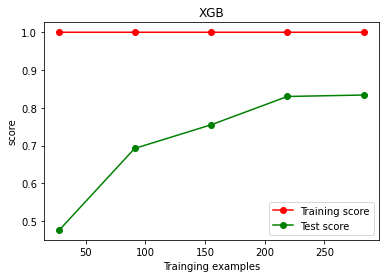

In [24]:
cv = KFold(n_splits=5, shuffle = True, random_state=42)
plot_learning_curve(XGBR(n_estimators=100,random_state=420)
,"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

### 参数学习曲线观察n_estimators 


110 9.03535374348125


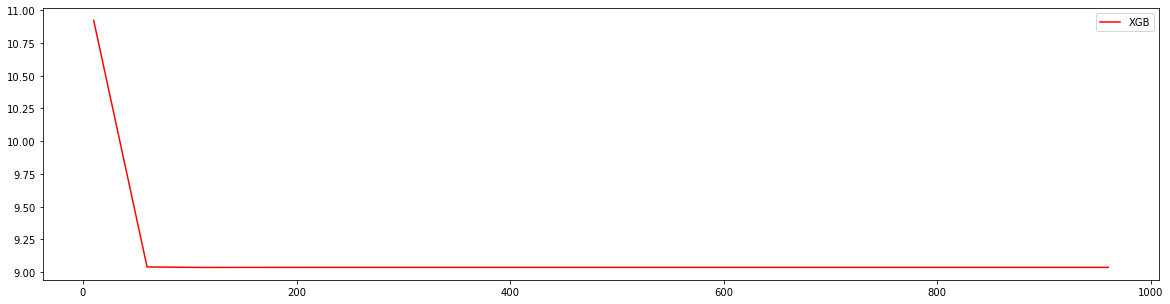

In [26]:
axisx = range(10,1010,50) 
rs = [] 
for i in axisx: 
    reg = XGBR(n_estimators = i, random_state = 420) 
    rs.append(-1 * CVS(reg,X,y,cv = cv,scoring = 'neg_mean_squared_error').mean()) 
print(axisx[rs.index(min(rs))],min(rs)) 
plt.figure(figsize = (20,5)) 
plt.plot(axisx,rs, c = 'red',label = 'XGB') 
plt.legend() 
plt.show() 

### 有放回随机抽样： subsample

1.0 0.8925016376343864


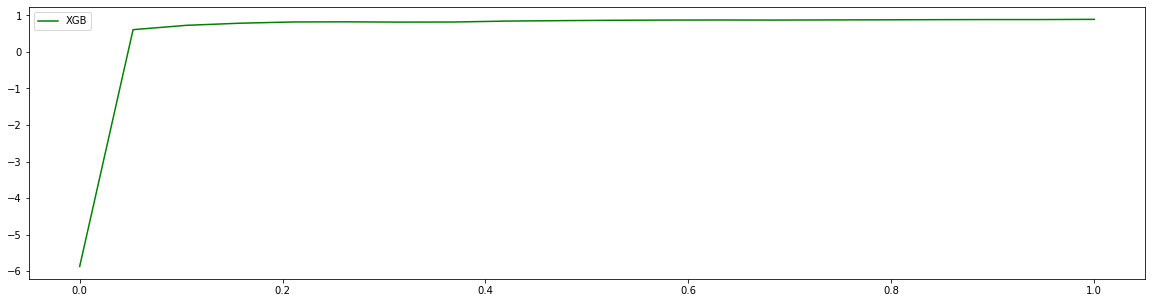

In [29]:
axisx = np.linspace(0,1,20) 
rs = [] 
for i in axisx: 
    reg = XGBR(n_estimators = 110, subsample = i, random_state = 420) 
    rs.append( CVS(reg,X,y,cv = cv).mean()) 

print(axisx[rs.index(max(rs))],max(rs)) 
plt.figure(figsize = (20,5)) 
plt.plot(axisx, rs, c = 'green',label = 'XGB') 
plt.legend() 
plt.show() 

### 迭代决策树：重要参数eta 

In [30]:
def regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2"],show=True):
    score = []
    for i in range(len(scoring)):
        if show:
            print("{}:{:.2f}".format(scoring[i]
,CVS(reg
,Xtrain,Ytrain
,cv=cv,scoring=scoring[i]).mean()))
            score.append(CVS(reg,Xtrain,Ytrain,cv=cv,scoring=scoring[i]).mean())
    return score

In [31]:
regassess(reg,Xtrain,Ytrain,cv,scoring = ['r2','neg_mean_squared_error']) 

r2:0.83
neg_mean_squared_error:-12.11


[0.8320726370396294, -12.109019124782568]

In [32]:
regassess(reg,Xtrain,Ytrain,cv,scoring = ['r2','neg_mean_squared_error'],show = False)  

[]

In [33]:
from time import time 
import datetime 

for i in [0,0.2,0.5,1]: 
    time0 = time() 
    reg = XGBR(n_estimators = 110,random_state = 420, 
                learning_rate = i) 
    print('learning_rate  ={}'.format(i)) 
    regassess(reg,Xtrain,Ytrain,cv,scoring = ['r2','neg_mean_squared_error']) 
    print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f')) 
    print('\t') 

learning_rate  =0
r2:-6.76
neg_mean_squared_error:-567.55
00:02:026342
	
learning_rate  =0.2
r2:0.83
neg_mean_squared_error:-12.30
00:03:291452
	
learning_rate  =0.5
r2:0.82
neg_mean_squared_error:-12.48
00:02:383120
	
learning_rate  =1
r2:0.71
neg_mean_squared_error:-20.06
00:01:684590
	


r2:0.82
neg_mean_squared_error:-12.81
r2:0.84
neg_mean_squared_error:-12.02
r2:0.83
neg_mean_squared_error:-12.55
r2:0.83
neg_mean_squared_error:-12.30
r2:0.82
neg_mean_squared_error:-13.37
r2:0.83
neg_mean_squared_error:-12.11
r2:0.81
neg_mean_squared_error:-13.97
r2:0.80
neg_mean_squared_error:-14.57
r2:0.79
neg_mean_squared_error:-15.01
r2:0.82
neg_mean_squared_error:-12.48
r2:0.80
neg_mean_squared_error:-14.17
r2:0.80
neg_mean_squared_error:-14.49
r2:0.77
neg_mean_squared_error:-16.00
r2:0.80
neg_mean_squared_error:-13.59
r2:0.72
neg_mean_squared_error:-19.66
r2:0.69
neg_mean_squared_error:-21.94
r2:0.74
neg_mean_squared_error:-18.58
r2:0.68
neg_mean_squared_error:-21.87
r2:0.72
neg_mean_squared_error:-20.25
0.1 0.8350716290107739


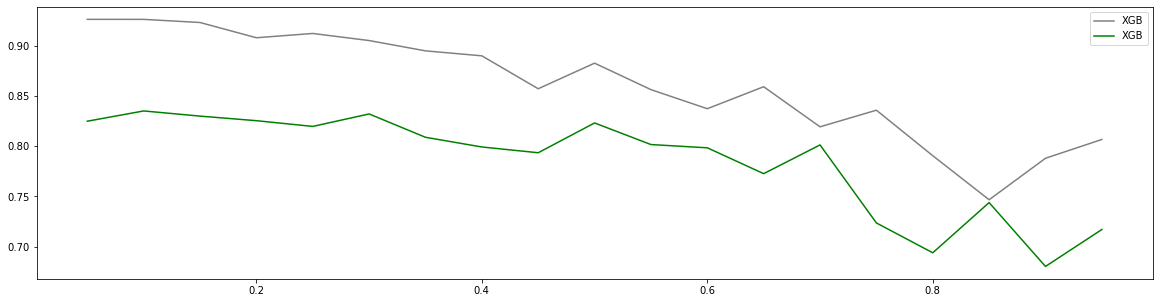

In [37]:
axisx = np.arange(0.05,1,0.05) 
rs = [] 
te = []  
for i in axisx: 
    reg = XGBR(n_estimators = 110, random_state = 420, learning_rate = i) 
    score = regassess(reg,Xtrain,Ytrain,cv,scoring = ['r2','neg_mean_squared_error']) 
    test = reg.fit(Xtrain,Ytrain).score(Xtest,Ytest) 
    rs.append(score[0])  
    te.append(test) 

print(axisx[rs.index(max(rs))],max(rs)) 
plt.figure(figsize = (20,5)) 
plt.plot(axisx,te,c = 'gray',label = 'XGB') 
plt.plot(axisx,rs,c = 'green',label = 'XGB') 
plt.legend()
plt.show() 

### 让树停止生长：重要参数gamma 

0.8 0.840869937975637 0.005891402581053541
4.55 0.8270850835330702 0.004605425533747813
0.8 0.840869937975637 0.005891402581053541 0.2988291499899019


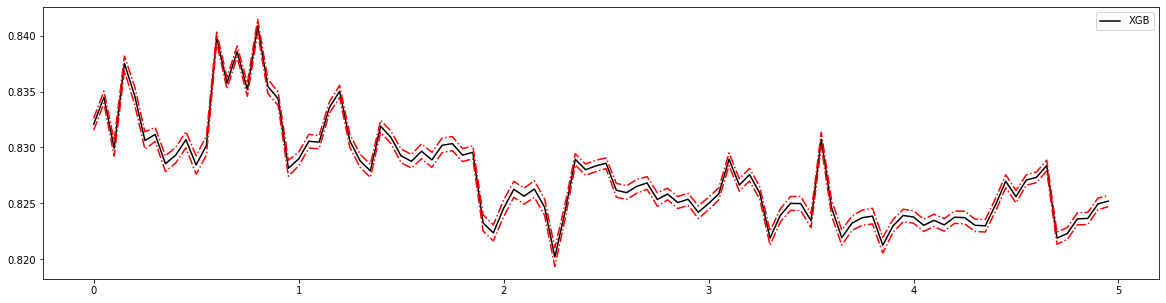

In [38]:
axisx = np.arange(0,5,0.05) 
rs = [] 
var = [] 
ge = [] 
for i in axisx: 
    reg = XGBR(n_estimators = 180, random_state = 420,gamma = i) 
    result = CVS(reg,Xtrain,Ytrain,cv = cv) 
    rs.append(result.mean()) 
    var.append(result.var()) 
    ge.append(1- result.mean()**2 + result.var()) 
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))]) 
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var)) 
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge)) 
rs = np.array(rs) 
var = np.array(var)*0.1 
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

### xgb.cv 

In [41]:
import xgboost as xgb 
dfull = xgb.DMatrix(X,y ) 
# 设定参数 
param1 = {'silent':True, 'obj':'reg:linear','gamma':0} 
num_round = 180 
n_fold = 5 
# 使用类xgb.cv 
time0 = time() 
cvresult = xgb.cv(param1, dfull, num_round, n_fold) 
print(datetime.datetime.fromtimestamp(time() - time0).strftime('%M:%s:%f')) 

[14:06:01] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:06:01] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:06:01] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being 

In [42]:
cvresult 

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105578,0.129116,17.163215,0.584297
1,12.337972,0.097557,12.519735,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629481,0.050323,7.250335,0.500342
4,4.954406,0.033209,5.920812,0.591874
...,...,...,...,...
175,0.001299,0.000289,3.669898,0.857676
176,0.001285,0.000261,3.669897,0.857677
177,0.001275,0.000239,3.669903,0.857669
178,0.001263,0.000217,3.669901,0.857672


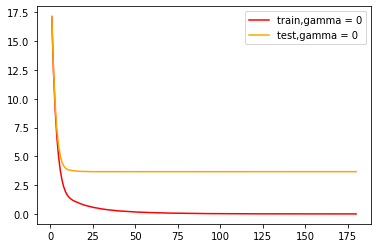

In [43]:
plt.plot(range(1,181),cvresult.iloc[:,0],c = 'red',label = 'train,gamma = 0') 
plt.plot(range(1,181),cvresult.iloc[:,2],c = 'orange',label = 'test,gamma = 0') 
plt.legend() 
plt.show() 

[14:28:38] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:28:38] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:28:38] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being 

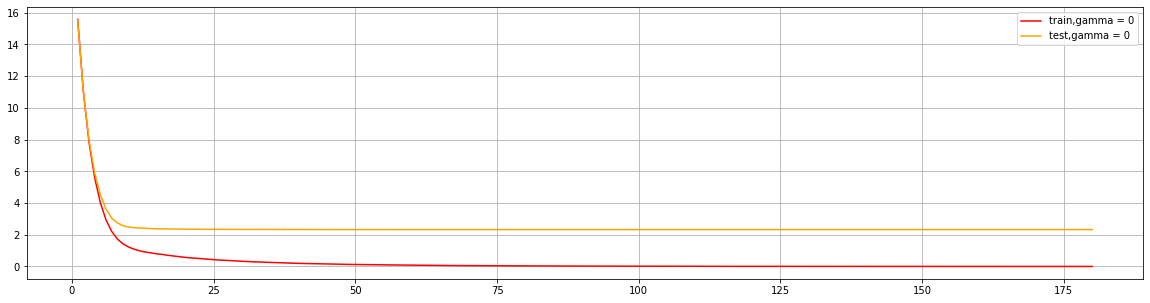

In [44]:
param2 = {'silent': True,'obj':'reg:linear','gamma':0,'eval_metric': 'mae'} 
cvresult1 = xgb.cv(param2, dfull, num_round,n_fold) 

plt.figure(figsize = (20,5)) 
plt.grid() 
plt.plot(range(1,181),cvresult1.iloc[:,0],c = 'red',label = 'train,gamma = 0') 
plt.plot(range(1,181),cvresult1.iloc[:,2],c = 'orange',label = 'test,gamma = 0') 
plt.legend() 
plt.show() 

In [45]:
# 调整gamma 
param1 = {'silent':False,'obj':'reg:linear','gamma':0} 
param2 = {'silent':False,'obj':'reg:linear','gamma':20} 

num_round = 180 
n_fold = 5 

time0 = time() 
cvresult1 = xgb.cv(param1,dfull, num_round, n_fold) 

print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f')) 


[14:34:10] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:34:10] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:34:10] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being 

In [46]:
time0 = time() 
cvresult2 = xgb.cv(param2,dfull,num_round,n_fold) 
print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f')) 

[14:37:50] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:37:50] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:37:50] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being 

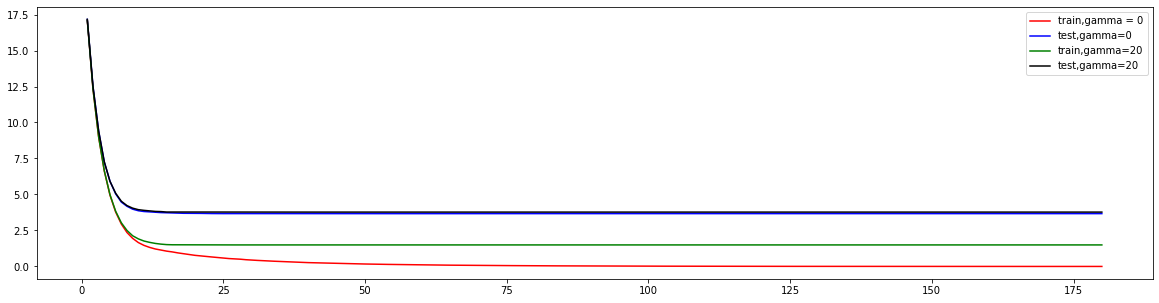

In [47]:
plt.figure(figsize = (20,5)) 
plt.plot(range(1,181),cvresult1.iloc[:,0],c = 'red',label = 'train,gamma = 0') 
plt.plot(range(1,181),cvresult1.iloc[:,2],c = 'blue',label = 'test,gamma=0') 
plt.plot(range(1,181),cvresult2.iloc[:,0],c = 'green',label = 'train,gamma=20') 
plt.plot(range(1,181),cvresult2.iloc[:,2],c = 'black',label = 'test,gamma=20') 
plt.legend() 
plt.show() 

### 试一个例子 

In [48]:
from sklearn.datasets import load_breast_cancer 
data2 = load_breast_cancer() 

x2 = data2.data 
y2 = data2.target 

dfull2 = xgb.DMatrix(x2,y2) 
param1 = {'silent':True,'obj':'binary:logistic','gamma':0,'n_fold': 5} 
param2 = {'silent':True,'obj':'binary:logistic','gamma':2,'n_fold': 5}  

num_round = 100 


In [49]:

time0 = time() 
cvresult1 = xgb.cv(param1,dfull2,num_round,metrics = ('error')) 
print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))  

[14:50:47] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:47] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:47] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

In [50]:

time0 = time() 
cvresult2 = xgb.cv(param2,dfull2,num_round,metrics = ('error')) 
print(datetime.datetime.fromtimestamp(time()-time0).strftime('%M:%S:%f'))  

[14:50:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:50:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_fold", "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or 

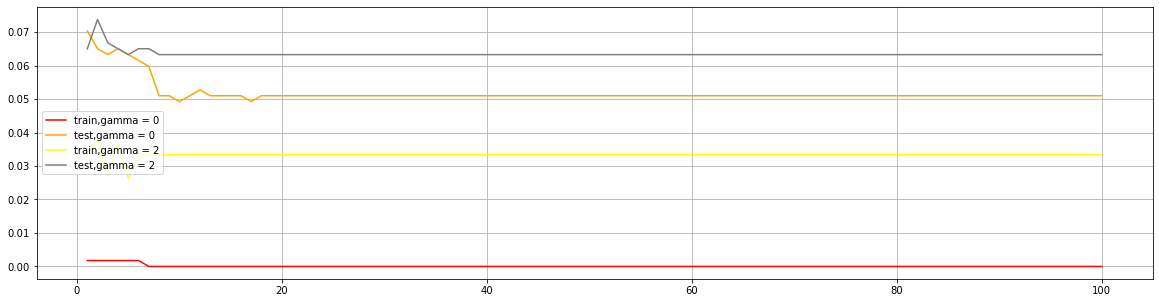

In [51]:
plt.figure(figsize = (20,5)) 
plt.grid() 
plt.plot(range(1,101),cvresult1.iloc[:,0],c = 'red',label = 'train,gamma = 0') 
plt.plot(range(1,101),cvresult1.iloc[:,2],c = 'orange',label = 'test,gamma = 0')  
plt.plot(range(1,101),cvresult2.iloc[:,0],c = 'yellow',label = 'train,gamma = 2')
plt.plot(range(1,101),cvresult2.iloc[:,2],c = 'gray',label = 'test,gamma = 2') 
plt.legend() 
plt.show() 
  

### 使用pickle保存模型 

In [52]:
import pickle 

In [53]:
dtrain = xgb.DMatrix(Xtrain,Ytrain) 
# 设定参数，对模型训练 
param = {'silent':True, 
        'obj':'reg:linear', 
        'subsample':1,  
        'eta':0.05, 
        'gamma':20, 
        'lambda':3.5, 
        'alpha':0.2, 
        'max_depth':4, 
        "colsample_bytree":0.4
        ,"colsample_bylevel":0.6
        ,"colsample_bynode":1} 

num_round = 180 
bst = xgb.train(param, dtrain, num_round) 
#保存模型 
pickle.dump(bst,open("xgboostonboston.dat","wb"))  

[15:12:09] WARNING: ../src/learner.cc:576: 
Parameters: { "obj", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




在另一个notebook上test.ipynb导入模型 